In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [25]:
# Tentukan path untuk data
train_data_dir = "/Users/anggun/Downloads/SKRIPSI ANGGUN/ANGGUN/2. Data Train & Validation"
test_data_dir = "/Users/anggun/Downloads/SKRIPSI ANGGUN/ANGGUN/2. Data Test"

In [26]:
# Fungsi untuk memuat data dari folder dan mengembalikan generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Fungsi untuk memuat data dari folder dan mengembalikan generator
def load_data(data_dir, batch_size=32, target_size=(299, 299)):
    data_generator = ImageDataGenerator(rescale=1./255)

    data_flow = data_generator.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',  # untuk label one-hot
        shuffle=True
    )
    return data_flow


In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Fungsi augmentasi khusus
def custom_augmentation(x):
    if np.random.random() < 0.5:
        x = np.flip(x, axis=1)  # Flip horizontal
    if np.random.random() < 0.5:
        x = np.flip(x, axis=0)  # Flip vertikal
    if np.random.random() < 0.5:
        x = tf.keras.preprocessing.image.random_rotation(x, 90, row_axis=0, col_axis=1, channel_axis=2)  # Rotate right (90 derajat)
    if np.random.random() < 0.5:
        x = tf.keras.preprocessing.image.random_rotation(x, -90, row_axis=0, col_axis=1, channel_axis=2)  # Rotate left (-90 derajat)
    return x

# Data generator dengan augmentasi
data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_augmentation
)

# Aliran data
data_flow = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 540 images belonging to 3 classes.


In [ ]:
############

In [28]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_augmentation,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)


In [ ]:
##############

In [30]:
# Memuat data train ke dalam array
X_data = []
y_data = []

In [31]:
# Loop through batches using the iterator protocol (no need for next())
for i, (X_batch, y_batch) in enumerate(data_flow):
    X_data.append(X_batch)
    y_data.append(y_batch)
    
    # Exit the loop once we've got all the batches (although this is redundant because ⁠ data_flow ⁠ handles it)
    if i >= len(data_flow) - 1:
        break
# Memuat data test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(299, 299),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 60 images belonging to 3 classes.


In [32]:
X_data = np.concatenate(X_data)
y_data = np.concatenate(y_data)

In [33]:
# model Xception
import tensorflow as tf

def create_xception_model():
    # Load base model Xception dengan pretrained weights dan tanpa top classifier
    base_model = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)
    )
    base_model.trainable = False  # Bekukan bobot pretrained

    # Bangun model dengan top layers tambahan
    model_xception = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),           # Lebih efisien dari Flatten
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')      # Output untuk 3 kelas
    ])

    # Kompilasi model
    model_xception.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model_xception


In [34]:
#n_split = 4 artinya jumlah KFold adalah 4 kali
#shuffle=True saat pelatihan, maka data akan diacak setiap kali memasuki epoch baru, jika shuffle=False maka urutan data tetap sama untuk setiap epoch
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

In [35]:
# ====== 2. IMPORT LIBRARY LAIN ======
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

# Misalnya, Anda telah mengumpulkan histori dari setiap fold
fold_accuracies = []
fold_losses = []
fold_val_accuracies = []
fold_val_losses = []
fold_accuracy = []
y_true_val = []
y_pred_val = []
y_true_test = []
y_pred_test = []
confusion_matrices=[]
fold_summaries = []


for fold, (train_index, val_index) in enumerate (kfold.split(X_data)):
    X_train, X_val = X_data[train_index], X_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]
    
    modelxception = create_xception_model()
    history = modelxception.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=10,
        validation_data=(X_val, y_val)
    )
    #evaluasi
    _, accuracy = modelxception.evaluate(X_val, y_val)
    fold_accuracy.append(accuracy)
    
    # Simpan histori dari setiap fold
    fold_accuracies.append(history.history['accuracy'])
    fold_losses.append(history.history['loss'])
    fold_val_accuracies.append(history.history['val_accuracy'])
    fold_val_losses.append(history.history['val_loss'])
    
    # Prediksi untuk data validasi
    y_pred_fold = np.argmax(modelxception.predict(X_val), axis=1)
    y_true_fold = np.argmax(y_val, axis=1)

    y_pred_val.extend(y_pred_fold)
    y_true_val.extend(y_true_fold)
# Menghitung confusion matrix
    cm = confusion_matrix(y_true_fold, y_pred_fold)
    confusion_matrices.append(cm)
    
    # Menghitung summary dari confusion matrix
    accuracy = accuracy_score(y_true_fold, y_pred_fold)
    precision = precision_score(y_true_fold, y_pred_fold, average='weighted')
    recall = recall_score(y_true_fold, y_pred_fold, average='weighted')
    f1 = f1_score(y_true_fold, y_pred_fold, average='weighted')
    fold_summaries.append((accuracy, precision, recall, f1))


    #Loss = seberapa jauh prediksi model dari label sebenarnya, jika prediksi salah (loss tinggi), jika prediksi benar (loss rendah)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 11s/step - accuracy: 0.5194 - loss: 0.9701 - val_accuracy: 0.7704 - val_loss: 0.6261
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 130s 10s/step - accuracy: 0.8419 - loss: 0.4576 - val_accuracy: 0.9111 - val_loss: 0.3184
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 140s 10s/step - accuracy: 0.8816 - loss: 0.3030 - val_accuracy: 0.9185 - val_loss: 0.2469
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 126s 10s/step - accuracy: 0.8999 - loss: 0.2889 - val_accuracy: 0.9333 - val_loss: 0.2146
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 121s 9s/step - accuracy: 0.9131 - loss: 0.2295 - val_accuracy: 0.8815 - val_loss: 0.2340
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 122s 10s/step - accuracy: 0.9324 - loss: 0.1871 - val_accuracy: 0.9481 - val_loss: 0.2046
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 118s 9s/step - accuracy: 0.9248 - loss: 0.2074 - val_accuracy: 0.9630 - val_loss: 0.1580
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 124s 10s/step - accuracy: 0.9488 - loss: 0.1417 - val_accuracy: 0.96

In [36]:
# Contoh output
print("Akurasi setiap fold:", fold_accuracy)
print("Prediksi validasi:", y_pred_val)
print("Label asli validasi:", y_true_val)
print("Prediksi test:", y_pred_test)
print("Label asli test:", y_true_test)

Akurasi setiap fold: [0.9333333373069763, 0.9185185432434082, 0.9407407641410828, 0.9259259104728699]
Prediksi validasi: [np.int64(2), np.int64(1), np.int64(0), np.int64(2), np.int64(0), np.int64(2), np.int64(2), np.int64(1), np.int64(2), np.int64(0), np.int64(1), np.int64(1), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(1), np.int64(1), np.int64(2), np.int64(0), np.int64(2), np.int64(0), np.int64(2), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(2), np.int64(0), np.int64(0), np.int64(2), np.int64(0), np.int64(2), np.int64(0), np.int64(2), np.int64(1), np.int64(2), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(2), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int6

In [37]:
modelxception.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,649,459 (82.59 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 525,320 (2.00 MB)

In [38]:
# Plotting grafik untuk semua fold
#epochs = range(1, 11) jika  epoch sebanyak 11
epochs = list(range(1, 11))  # 1 sampai 20

In [39]:
#Visualisasi Grafik Loss dan Accuracy
#Loss sebaiknya turun stabil dan tidak terlalu jauh jaraknya.
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12,5))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


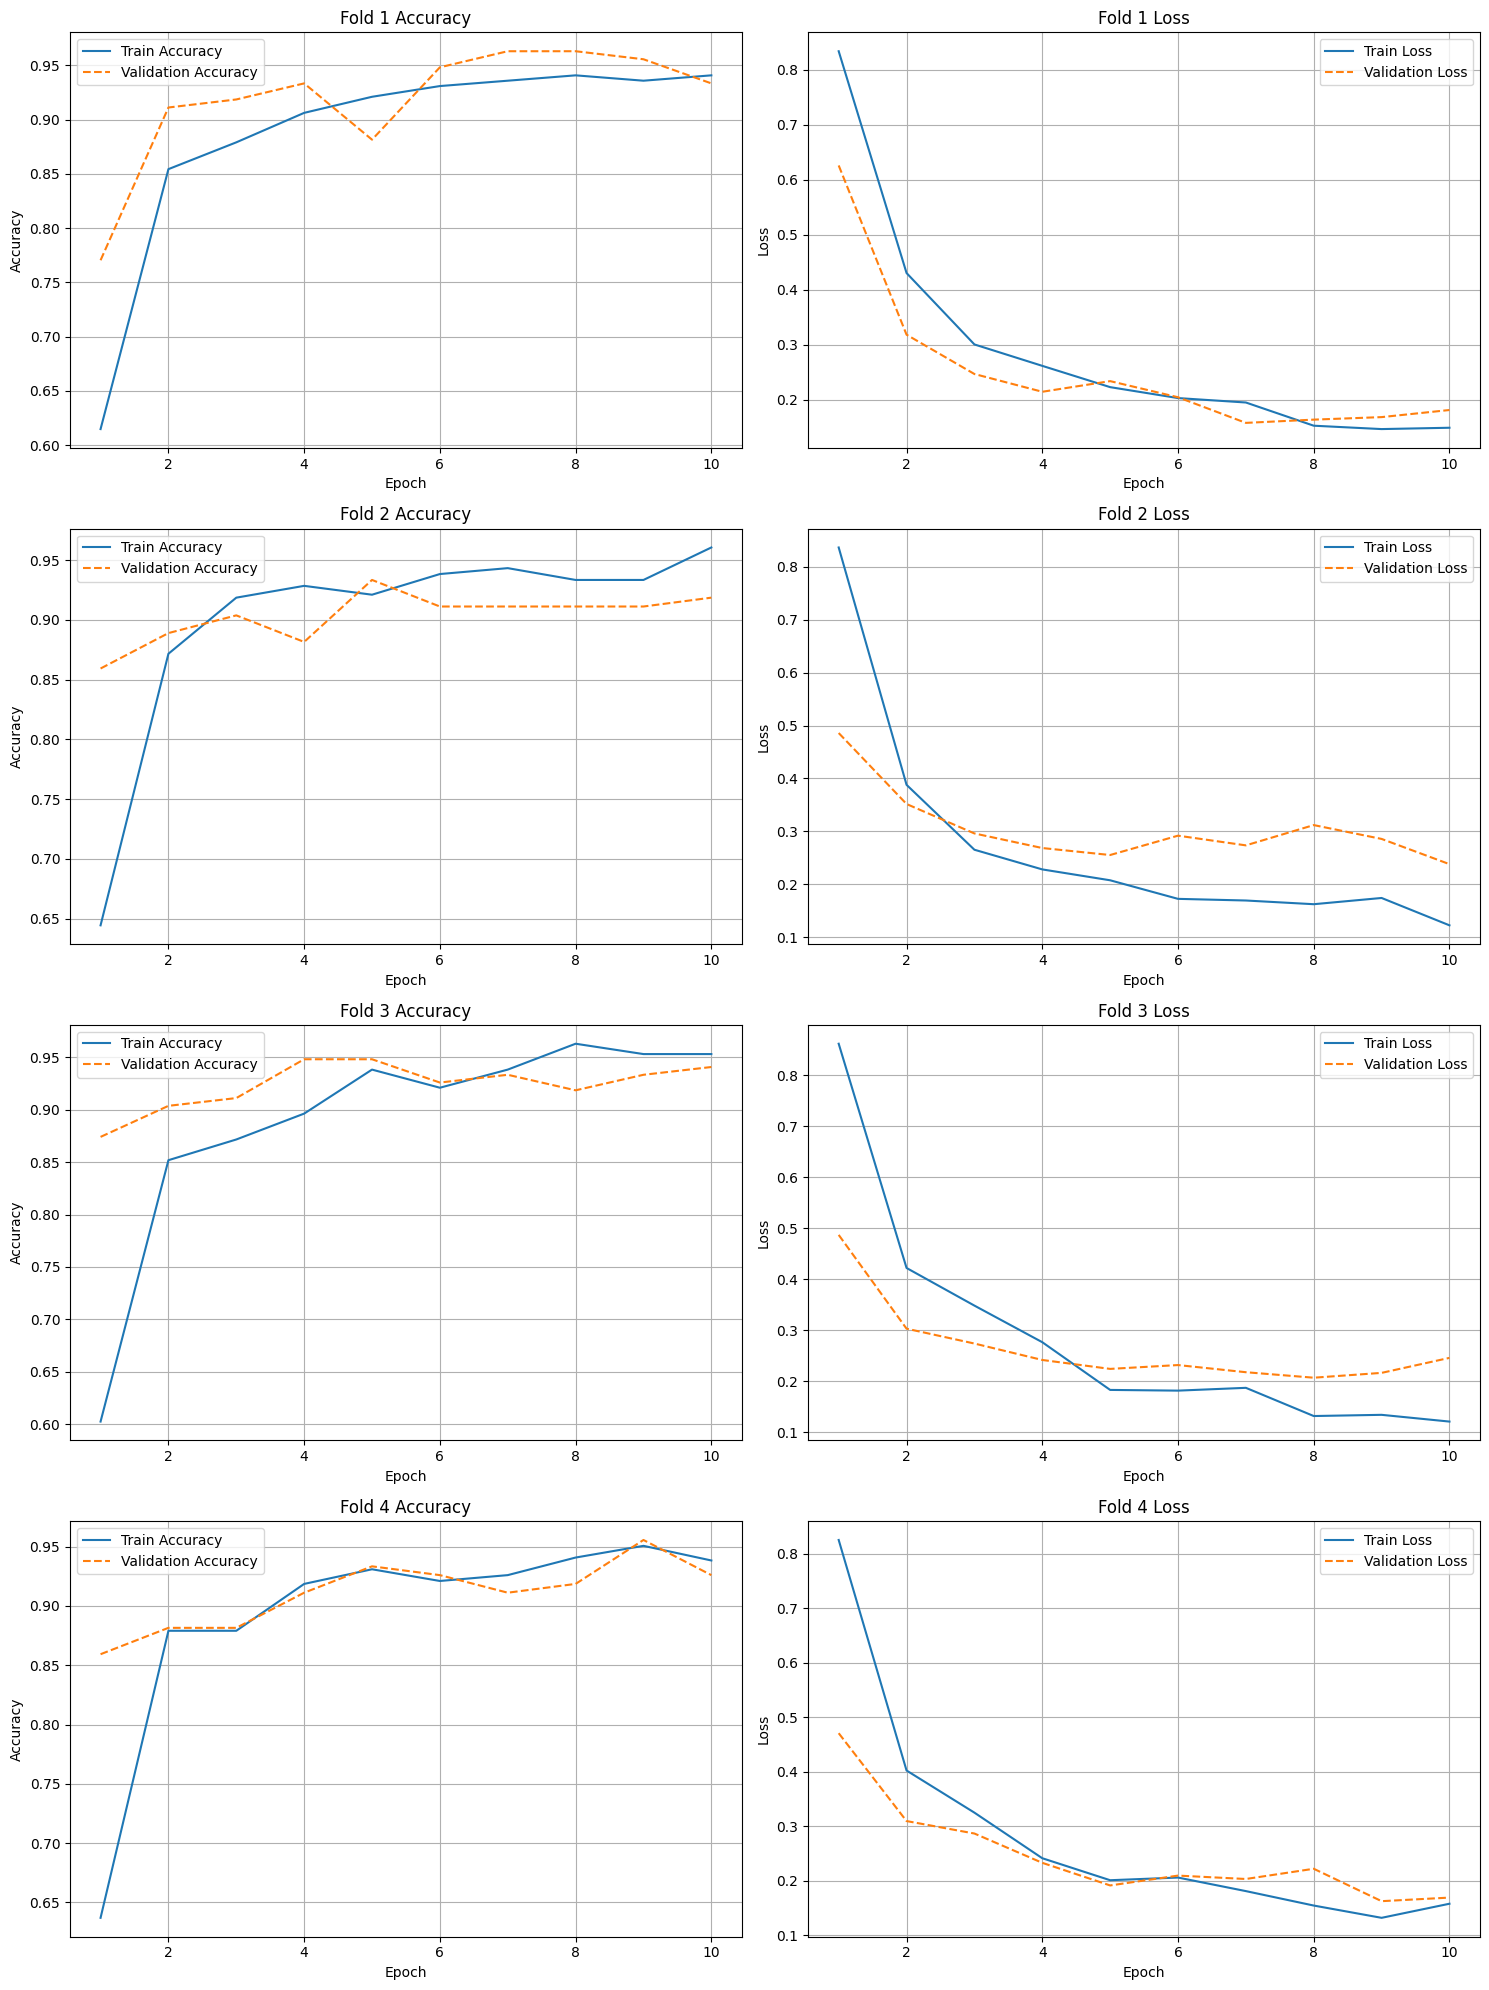

In [40]:
import matplotlib.pyplot as plt

# Pastikan fold_accuracies, fold_val_accuracies, fold_losses, fold_val_losses, dan epochs terdefinisi dengan benar

# Tentukan jumlah fold
num_folds = len(fold_accuracies)

# Setup subplot grid dengan 4 baris dan 2 kolom (total 8 grafik)
plt.figure(figsize=(15, 20))

for i in range(num_folds):
    # Subplot untuk Accuracy
    plt.subplot(num_folds, 2, 2 * i + 1)
    plt.plot(epochs, fold_accuracies[i], label='Train Accuracy')
    plt.plot(epochs, fold_val_accuracies[i], label='Validation Accuracy', linestyle='--')
    plt.title(f'Fold {i + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Subplot untuk Loss
    plt.subplot(num_folds, 2, 2 * i + 2)
    plt.plot(epochs, fold_losses[i], label='Train Loss')
    plt.plot(epochs, fold_val_losses[i], label='Validation Loss', linestyle='--')
    plt.title(f'Fold {i + 1} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

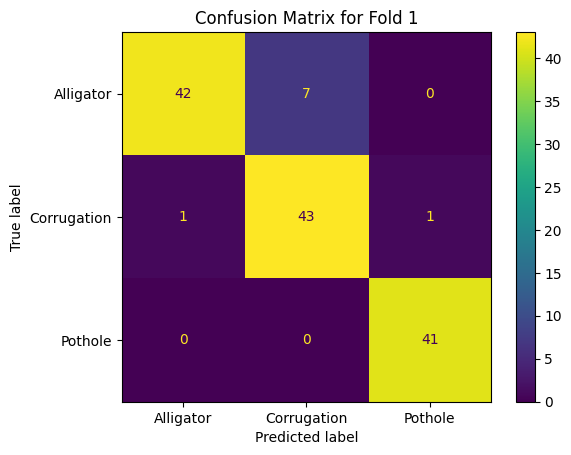

Summary for Fold 1:
Accuracy: 0.9333333333333333
Precision: 0.9376612936302858
Recall: 0.9333333333333333
F1 Score: 0.9331999750846764




<Figure size 640x480 with 0 Axes>

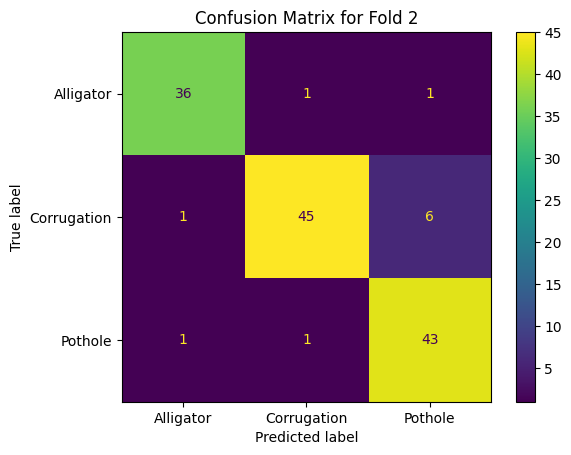

Summary for Fold 2:
Accuracy: 0.9185185185185185
Precision: 0.9221276595744682
Recall: 0.9185185185185185
F1 Score: 0.9185894027999291




<Figure size 640x480 with 0 Axes>

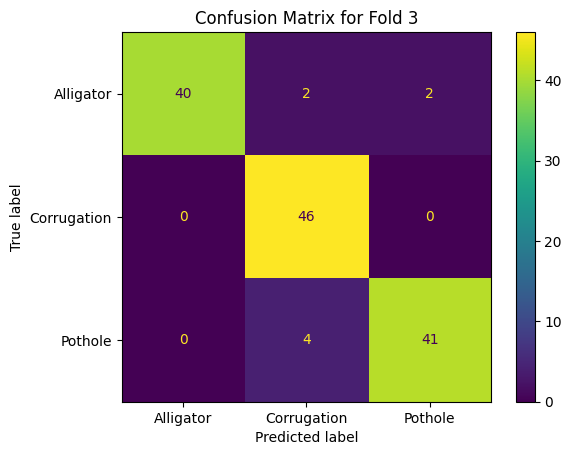

Summary for Fold 3:
Accuracy: 0.9407407407407408
Precision: 0.9451798847147685
Recall: 0.9407407407407408
F1 Score: 0.9408907670812434




<Figure size 640x480 with 0 Axes>

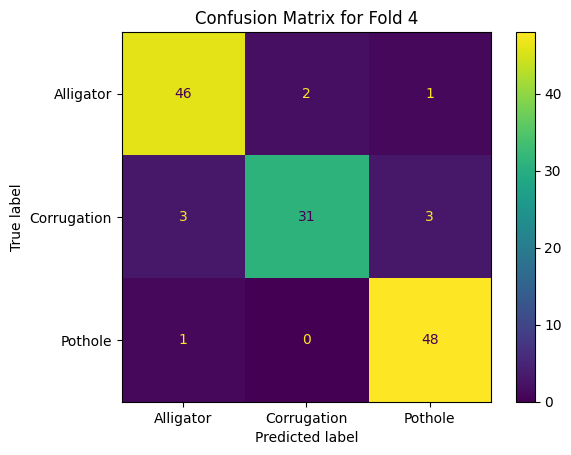

Summary for Fold 4:
Accuracy: 0.9259259259259259
Precision: 0.9264321850988517
Recall: 0.9259259259259259
F1 Score: 0.9250447372779605




In [41]:
# Menampilkan confusion matrices dan summaries setelah loop selesai
for i, cm in enumerate(confusion_matrices):
    plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_flow.class_indices.keys())
    disp.plot()
    plt.title(f'Confusion Matrix for Fold {i + 1}')
    plt.show()
    
    accuracy, precision, recall, f1 = fold_summaries[i]
    print(f"Summary for Fold {i + 1}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("\n")

In [42]:
# Menampilkan rata-rata akurasi dari cross-validation
print("Cross-validation accuracy:", np.mean(fold_accuracy))

Cross-validation accuracy: 0.9296296387910843


In [43]:
# Menghitung confusion matrix
cm = confusion_matrix(y_true_fold, y_pred_fold)
confusion_matrices.append(cm)

In [44]:
# Menampilkan confusion matrices
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Fold {i + 1}:\n{cm}\n")

Confusion Matrix for Fold 1:
[[42  7  0]
 [ 1 43  1]
 [ 0  0 41]]

Confusion Matrix for Fold 2:
[[36  1  1]
 [ 1 45  6]
 [ 1  1 43]]

Confusion Matrix for Fold 3:
[[40  2  2]
 [ 0 46  0]
 [ 0  4 41]]

Confusion Matrix for Fold 4:
[[46  2  1]
 [ 3 31  3]
 [ 1  0 48]]

Confusion Matrix for Fold 5:
[[46  2  1]
 [ 3 31  3]
 [ 1  0 48]]



/opt/anaconda3/envs/Anggun/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 220ms/step - accuracy: 0.9828 - loss: 0.1041
Test Accuracy: 0.9666666388511658
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step


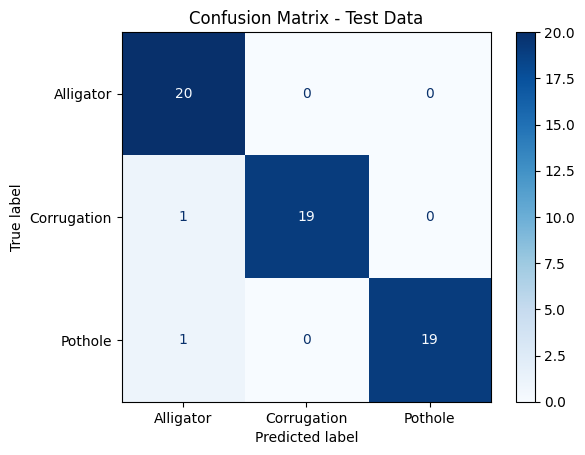

              precision    recall  f1-score   support

   Alligator       0.91      1.00      0.95        20
 Corrugation       1.00      0.95      0.97        20
     Pothole       1.00      0.95      0.97        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



In [45]:
test_scores = modelxception.evaluate(test_generator)
print("Test Accuracy:", test_scores[1])
# Prediksi dari model
y_pred_test = modelxception.predict(test_generator)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Label sebenarnya
y_true_test = test_generator.classes

# Hitung confusion matrix
test_cm = confusion_matrix(y_true_test, y_pred_test_classes)

# Nama kelas
classes = list(test_generator.class_indices.keys())

# Tampilkan confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=classes)
disp_test.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Data')
plt.show()

# Tampilkan laporan klasifikasi
print(classification_report(y_true_test, y_pred_test_classes, target_names=classes))

In [49]:
# Menghitung confusion matrix
cm = confusion_matrix(y_true_fold, y_pred_fold)
confusion_matrices.append(cm)

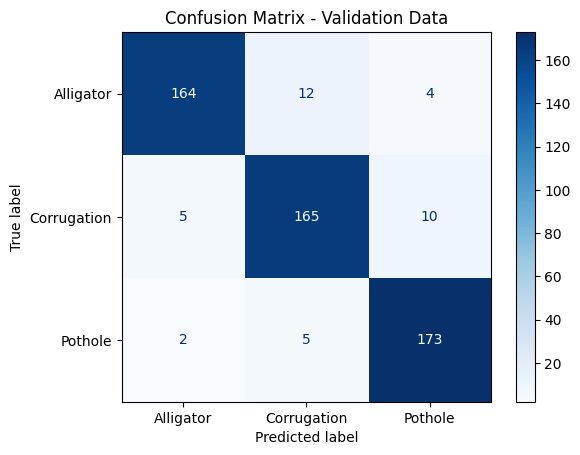

In [55]:
# Menghitung dan menampilkan confusion matrix untuk data validasi
val_cm = confusion_matrix(y_true_val, y_pred_val)
classes = list(test_generator.class_indices.keys())
disp_val = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=classes)
disp_val.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.show()

In [56]:
# Menampilkan precision, recall, f1-score, dan accuracy dari hasil confusion matrix untuk data train
print(classification_report(y_true_val, y_pred_val, target_names=classes))

              precision    recall  f1-score   support

   Alligator       0.96      0.91      0.93       180
 Corrugation       0.91      0.92      0.91       180
     Pothole       0.93      0.96      0.94       180

    accuracy                           0.93       540
   macro avg       0.93      0.93      0.93       540
weighted avg       0.93      0.93      0.93       540



In [57]:
test_scores = modelxception.evaluate(test_generator)
print("Test Accuracy:", test_scores[1])

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9828 - loss: 0.1041
Test Accuracy: 0.9666666388511658


In [60]:
modelxception.save('xception_new10.h5')